# **Problem 2:  Image Inpainting: Interpolation vs. PDE-Based Inpainting**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np
import math

# A.

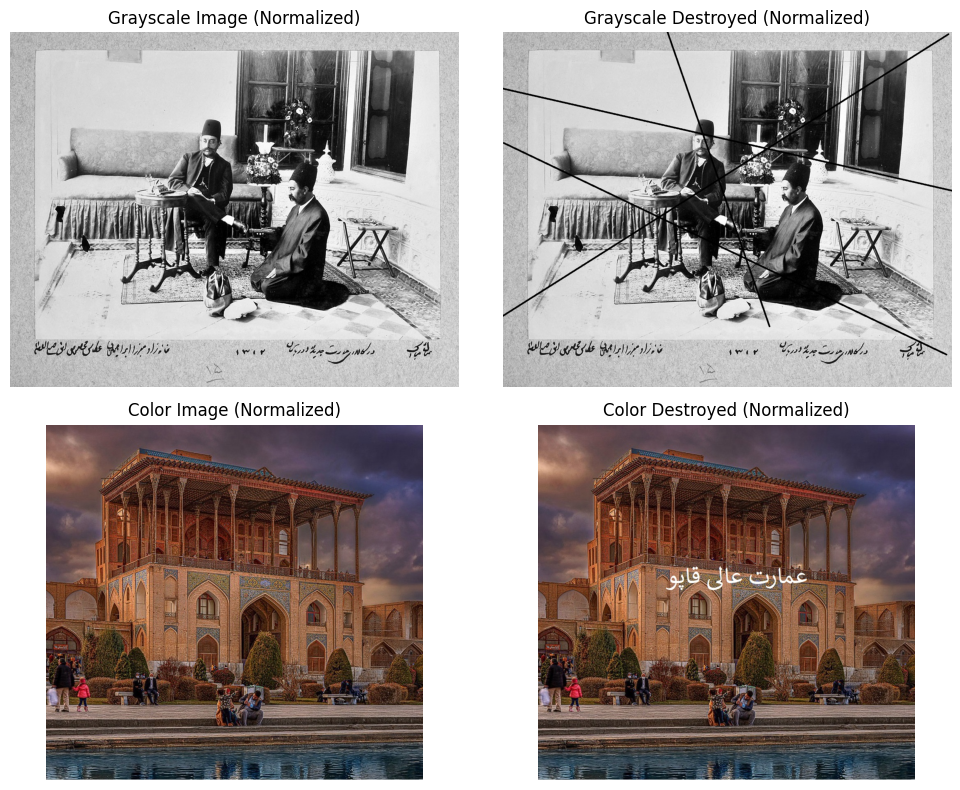

In [4]:
# Load and convert images to RGB and Grayscale
gray_image = cv2.imread('Q2_a.jpg', cv2.IMREAD_GRAYSCALE)
gray_destroyed = cv2.imread('Q2_a_destroyed.jpg', cv2.IMREAD_GRAYSCALE)

color_image = cv2.imread('Q2_b.jpg')
color_destroyed = cv2.imread('Q2_b_destroyed.jpg')
color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
color_destroyed = cv2.cvtColor(color_destroyed, cv2.COLOR_BGR2RGB)

#Normalize images to [0,1]
gray_image_norm = gray_image.astype(np.float32) / 255.0
gray_destroyed_norm = gray_destroyed.astype(np.float32) / 255.0

color_image_norm = color_image.astype(np.float32) / 255.0
color_destroyed_norm = color_destroyed.astype(np.float32) / 255.0

fig, axs = plt.subplots(2, 2, figsize=(10,8))

axs[0,0].imshow(gray_image_norm, cmap='gray')
axs[0,0].set_title('Grayscale Image (Normalized)')

axs[0,1].imshow(gray_destroyed_norm, cmap='gray')
axs[0,1].set_title('Grayscale Destroyed (Normalized)')

axs[1,0].imshow(color_image_norm)
axs[1,0].set_title('Color Image (Normalized)')

axs[1,1].imshow(color_destroyed_norm)
axs[1,1].set_title('Color Destroyed (Normalized)')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

# B.

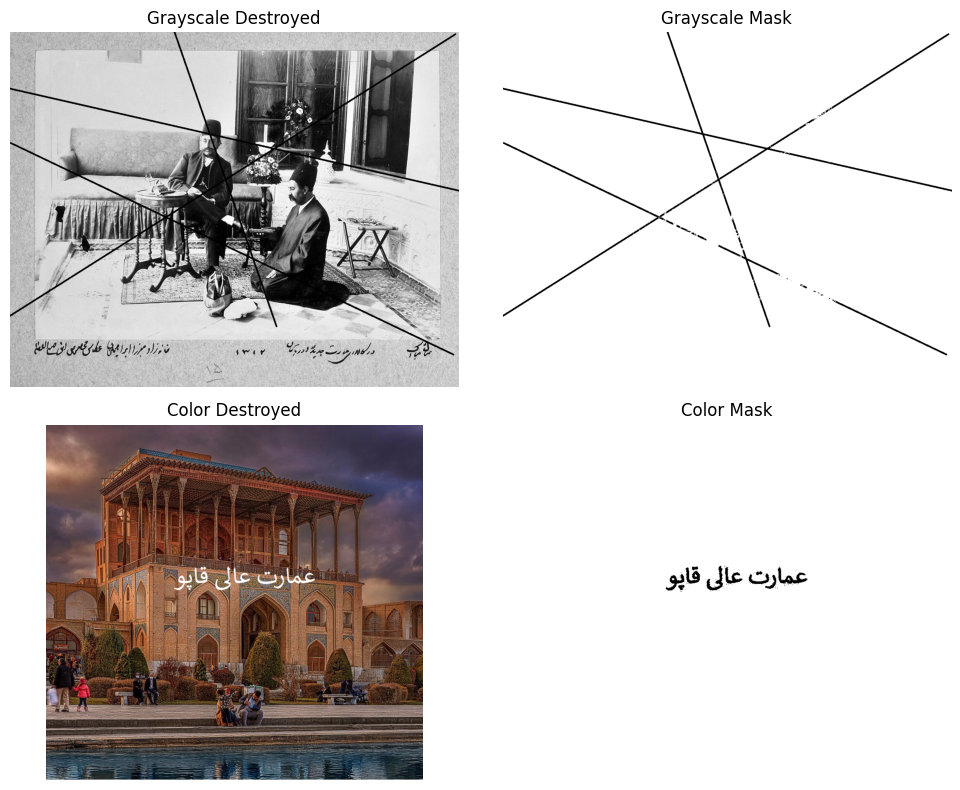

Grayscale Mask Shape: (1047, 1320) Value Range: 0 1
Color Mask Shape: (866, 918) Value Range: 0 1


In [9]:
# Grayscale & color damage masks
gray_mask = 1 - (np.abs(gray_image_norm - gray_destroyed_norm) > 0.05).astype(np.uint8)
color_mask = 1 - np.any(np.abs(color_image_norm - color_destroyed_norm) > 0.05, axis=2).astype(np.uint8)


# Display masks and destroyed images
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(gray_destroyed_norm, cmap='gray')
axs[0, 0].set_title('Grayscale Destroyed')
axs[0, 1].imshow(gray_mask, cmap='gray')
axs[0, 1].set_title('Grayscale Mask')
axs[1, 0].imshow(color_destroyed_norm)
axs[1, 0].set_title('Color Destroyed')
axs[1, 1].imshow(color_mask, cmap='gray')
axs[1, 1].set_title('Color Mask')
for ax in axs.flat:
    ax.axis('off')
plt.tight_layout()
plt.show()

print("Grayscale Mask Shape:", gray_mask.shape, "Value Range:", gray_mask.min(), gray_mask.max())
print("Color Mask Shape:", color_mask.shape, "Value Range:", color_mask.min(), color_mask.max())

# C.

In [ ]:
import numpy as np

def extract_intact_pixels(image, mask, image_name):
    # Extract coordinates of intact pixels
    intact_coords = np.where(mask == 1)
    intact_coords = np.column_stack((intact_coords[0], intact_coords[1]))  

    # Extract intensities
    if len(image.shape) == 2:  # Grayscale image
        intensities = image[mask == 1]  
    else:  # Color image
        intensities = {
            'R': image[mask == 1, 0],  
            'G': image[mask == 1, 1],  
            'B': image[mask == 1, 2]   
        }
    
    return {
        'image_name': image_name,
        'intact_coords': intact_coords,
        'intact_intensities': intensities,
        'num_intact_pixels': len(intact_coords)
    }

gray_extraction = extract_intact_pixels(gray_image_norm, gray_mask, "- Grayscale Image")
color_extraction = extract_intact_pixels(color_image_norm, color_mask, "- Color Image")

print(f"{gray_extraction['image_name']}:")
print(f" Number of Intact Pixels: {gray_extraction['num_intact_pixels']}")
print(f" Coordinates Shape: {gray_extraction['intact_coords'].shape}")
print(f" Intensities Shape: {gray_extraction['intact_intensities'].shape}")
print(f" First 5 Coordinates: \n{gray_extraction['intact_coords'][:5]}")
print(f" First 5 Intensities: \n{gray_extraction['intact_intensities'][:5]}")

print(f"\n{color_extraction['image_name']}:")
print(f" Number of Intact Pixels: {color_extraction['num_intact_pixels']}")
print(f" Coordinates Shape: {color_extraction['intact_coords'].shape}")
print(f" Intensities Shapes: R={color_extraction['intact_intensities']['R'].shape}, "
      f"G={color_extraction['intact_intensities']['G'].shape}, "
      f"B={color_extraction['intact_intensities']['B'].shape}")
print(f" First 5 Coordinates: \n{color_extraction['intact_coords'][:5]}")
print(f" First 5 Intensities (R): \n{color_extraction['intact_intensities']['R'][:5]}")
print(f" First 5 Intensities (G): \n{color_extraction['intact_intensities']['G'][:5]}")
print(f" First 5 Intensities (B): \n{color_extraction['intact_intensities']['B'][:5]}")

- Grayscale Image:
 Number of Intact Pixels: 1357555
 Coordinates Shape: (1357555, 2)
 Intensities Shape: (1357555,)
 First 5 Coordinates: 
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]]
 First 5 Intensities: 
[0.7529412  0.7490196  0.72156864 0.6901961  0.69803923]

- Color Image:
 Number of Intact Pixels: 790080
 Coordinates Shape: (790080, 2)
 Intensities Shapes: R=(790080,), G=(790080,), B=(790080,)
 First 5 Coordinates: 
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]]
 First 5 Intensities (R): 
[0.38431373 0.38431373 0.39215687 0.39607844 0.3882353 ]
 First 5 Intensities (G): 
[0.26666668 0.26666668 0.27450982 0.2784314  0.27058825]
 First 5 Intensities (B): 
[0.27450982 0.27450982 0.28235295 0.28627452 0.2784314 ]


# D.

In [25]:
def psnr(original, restored):
    mse = np.mean((original - restored) ** 2)
    if mse == 0:
        return float('inf')
    psnr = 20 * math.log10(1.0 / math.sqrt(mse))
    return psnr

# Perform image inpainting using scattered data interpolation
def inpaint_from_extracted(image_destroyed, mask, coords, values, method='nearest'):
    h, w = mask.shape
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))

    result = image_destroyed.copy()

    if image_destroyed.ndim == 2:  # Grayscale image
        fill_value = float(np.mean(values))   # Fallback for undefined areas
        interp = griddata(coords, values, (grid_y, grid_x), method=method, fill_value=fill_value)
        interp = np.clip(interp, 0.0, 1.0)
        result[mask == 0] = interp[mask == 0]
        return result

    elif image_destroyed.ndim == 3:  # Color image (RGB)
        for i, channel in enumerate(['R', 'G', 'B']):
            fill_value = float(np.mean(values[channel]))   # Fallback for undefined areas
            interp = griddata(coords, values[channel], (grid_y, grid_x), method=method, fill_value=fill_value)
            interp = np.clip(interp, 0.0, 1.0)
            result[..., i][mask == 0] = interp[mask == 0]
        return result

In [26]:
# Inpaint grayscale (nearest & linear)
gray_inpainted_nearest = inpaint_from_extracted(gray_destroyed_norm, gray_mask, 
    gray_extraction['intact_coords'], gray_extraction['intact_intensities'], method='nearest')

gray_inpainted_linear = inpaint_from_extracted(gray_destroyed_norm, gray_mask, gray_extraction['intact_coords'],
    gray_extraction['intact_intensities'], method='linear')

# Inpaint color (nearest & linear)
color_inpainted_nearest = inpaint_from_extracted(color_destroyed_norm, color_mask,
    color_extraction['intact_coords'], color_extraction['intact_intensities'], method='nearest')

color_inpainted_linear = inpaint_from_extracted(color_destroyed_norm, color_mask,
    color_extraction['intact_coords'], color_extraction['intact_intensities'], method='linear')

# Compute PSNR values
psnr_gray_nearest = psnr(gray_image_norm, gray_inpainted_nearest)
psnr_gray_linear = psnr(gray_image_norm, gray_inpainted_linear)
psnr_color_nearest = psnr(color_image_norm, color_inpainted_nearest)
psnr_color_linear = psnr(color_image_norm, color_inpainted_linear)


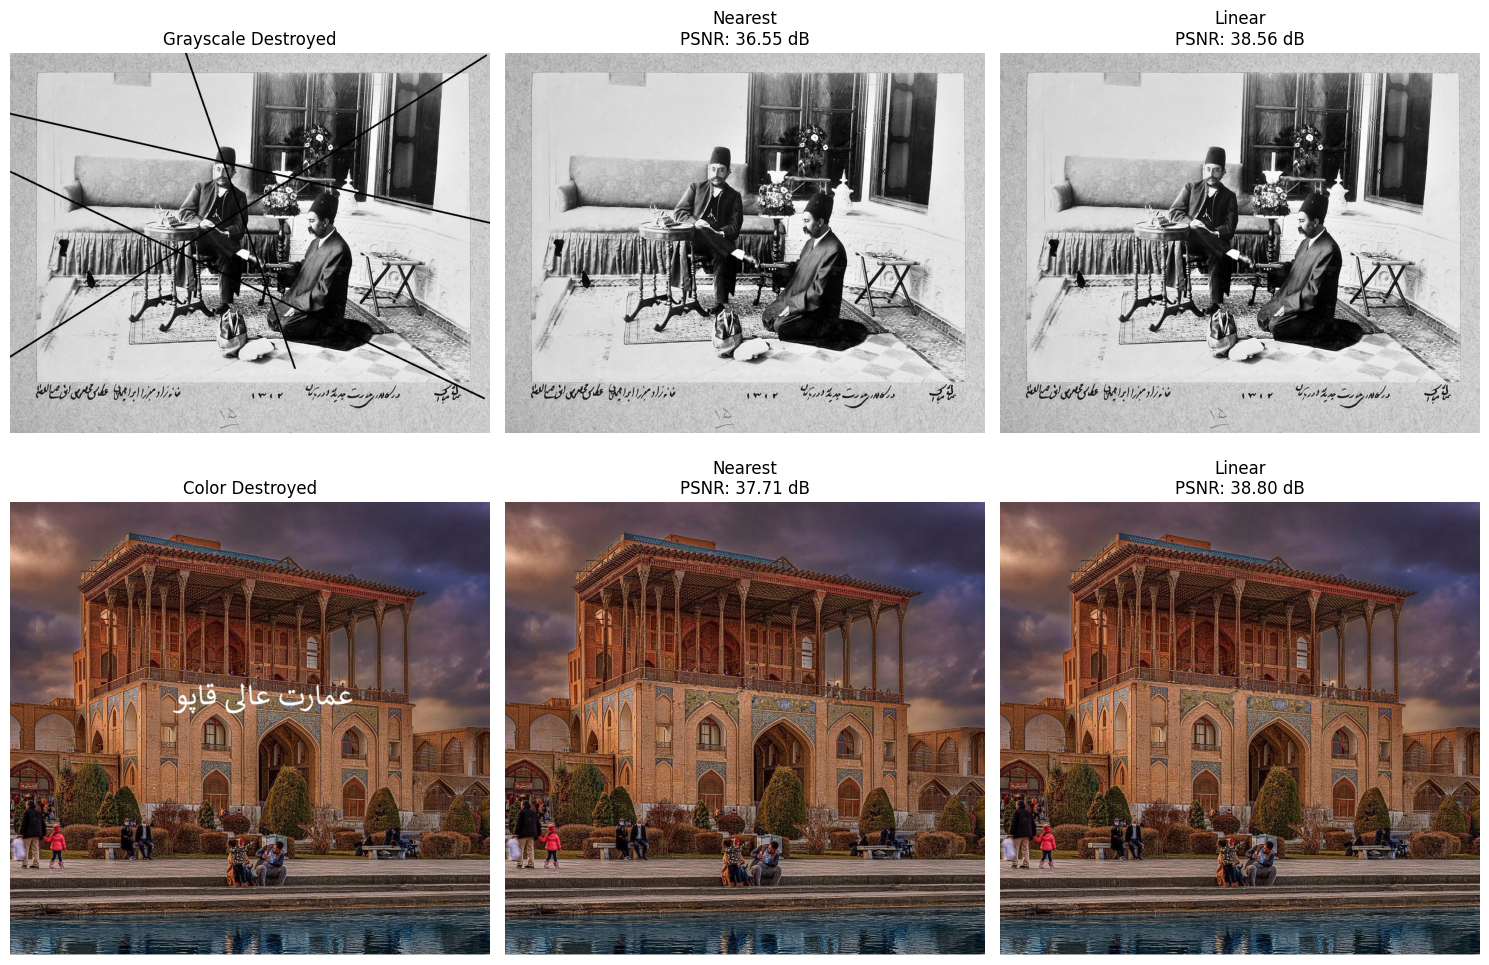

In [27]:
# Display inpainting results
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].imshow(gray_destroyed_norm, cmap='gray')
axs[0, 0].set_title('Grayscale Destroyed')

axs[0, 1].imshow(gray_inpainted_nearest, cmap='gray')
axs[0, 1].set_title(f'Nearest\nPSNR: {psnr_gray_nearest:.2f} dB')

axs[0, 2].imshow(gray_inpainted_linear, cmap='gray')
axs[0, 2].set_title(f'Linear\nPSNR: {psnr_gray_linear:.2f} dB')

axs[1, 0].imshow(color_destroyed_norm)
axs[1, 0].set_title('Color Destroyed')

axs[1, 1].imshow(color_inpainted_nearest)
axs[1, 1].set_title(f'Nearest\nPSNR: {psnr_color_nearest:.2f} dB')

axs[1, 2].imshow(color_inpainted_linear)
axs[1, 2].set_title(f'Linear\nPSNR: {psnr_color_linear:.2f} dB')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

# E.

'Explanation of this part in the report.'

# F.

'Explanation of this part in the report.'

# G.

In [55]:
def laplacian(u):
    lap = np.zeros_like(u, dtype=np.float64)
    # Interior pixels
    lap[1:-1, 1:-1] = (u[:-2, 1:-1] + u[2:, 1:-1] + u[1:-1, :-2] + u[1:-1, 2:] - 4 * u[1:-1, 1:-1])
    
    # Edges
    lap[0, 1:-1] = (u[1, 1:-1] + u[0, :-2] + u[0, 2:] - 3 * u[0, 1:-1])
    lap[-1, 1:-1] = (u[-2, 1:-1] + u[-1, :-2] + u[-1, 2:] - 3 * u[-1, 1:-1])
    lap[1:-1, 0] = (u[:-2, 0] + u[2:, 0] + u[1:-1, 1] - 3 * u[1:-1, 0])
    lap[1:-1, -1] = (u[:-2, -1] + u[2:, -1] + u[1:-1, -2] - 3 * u[1:-1, -1])
    
    # Corners
    lap[0, 0] = (u[1, 0] + u[0, 1] - 2 * u[0, 0])
    lap[0, -1] = (u[1, -1] + u[0, -2] - 2 * u[0, -1])
    lap[-1, 0] = (u[-2, 0] + u[-1, 1] - 2 * u[-1, 0])
    lap[-1, -1] = (u[-2, -1] + u[-1, -2] - 2 * u[-1, -1])
    
    return lap

def pde_inpainting(gray_destroyed, mask, lambda_param=0.05, num_iter=5000, dt=0.05):
    # Validate input shapes and values
    if gray_destroyed.shape != mask.shape:
        raise ValueError("Image and mask dimensions must match!")
    if not np.all((gray_destroyed >= 0) & (gray_destroyed <= 1)):
        raise ValueError("Image must be normalized between 0 and 1!")
    if not np.all(np.logical_or(mask == 0, mask == 1)):
        raise ValueError("Mask must be binary (0 or 1)!")
    
    if dt * lambda_param * 8 > 0.5:
        raise ValueError(f"Time step dt={dt} too large for lambda={lambda_param}. Reduce dt or lambda.")
    
    u = gray_destroyed.copy().astype(np.float64)
    f = gray_destroyed.copy()  # Fidelity image
    
    for _ in range(num_iter):
        lap = laplacian(u)   # Compute Laplacian
        du_dt = lambda_param * lap
        du_dt[mask == 1] += (f[mask == 1] - u[mask == 1])   # Fidelity term on intact pixels
        u += dt * du_dt   # Update image
        u = np.clip(u, 0.0, 1.0)
    
    return u

def pde_inpainting_color(color_destroyed, mask, lambda_param=0.05, num_iter=5000, dt=0.05):
    # Apply PDE inpainting independently on each RGB channel
    inpainted = color_destroyed.copy().astype(np.float64)
    for i in range(3):  # R, G, B channels
        inpainted[..., i] = pde_inpainting(inpainted[..., i], mask, lambda_param, num_iter, dt)
    return inpainted

# Compute PSNR
def psnr(original, restored):
    mse = np.mean((original - restored) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(1.0 / math.sqrt(mse))

In [ ]:
gray_pde_inpainted = pde_inpainting(gray_destroyed_norm, gray_mask, lambda_param=0.05, num_iter=5000, dt=0.05)
color_pde_inpainted = pde_inpainting_color(color_destroyed_norm, color_mask, lambda_param=0.05, num_iter=5000, dt=0.05)

# Compute PSNR
psnr_gray_pde = psnr(gray_image_norm, gray_pde_inpainted)
psnr_color_pde = psnr(color_image_norm, color_pde_inpainted)

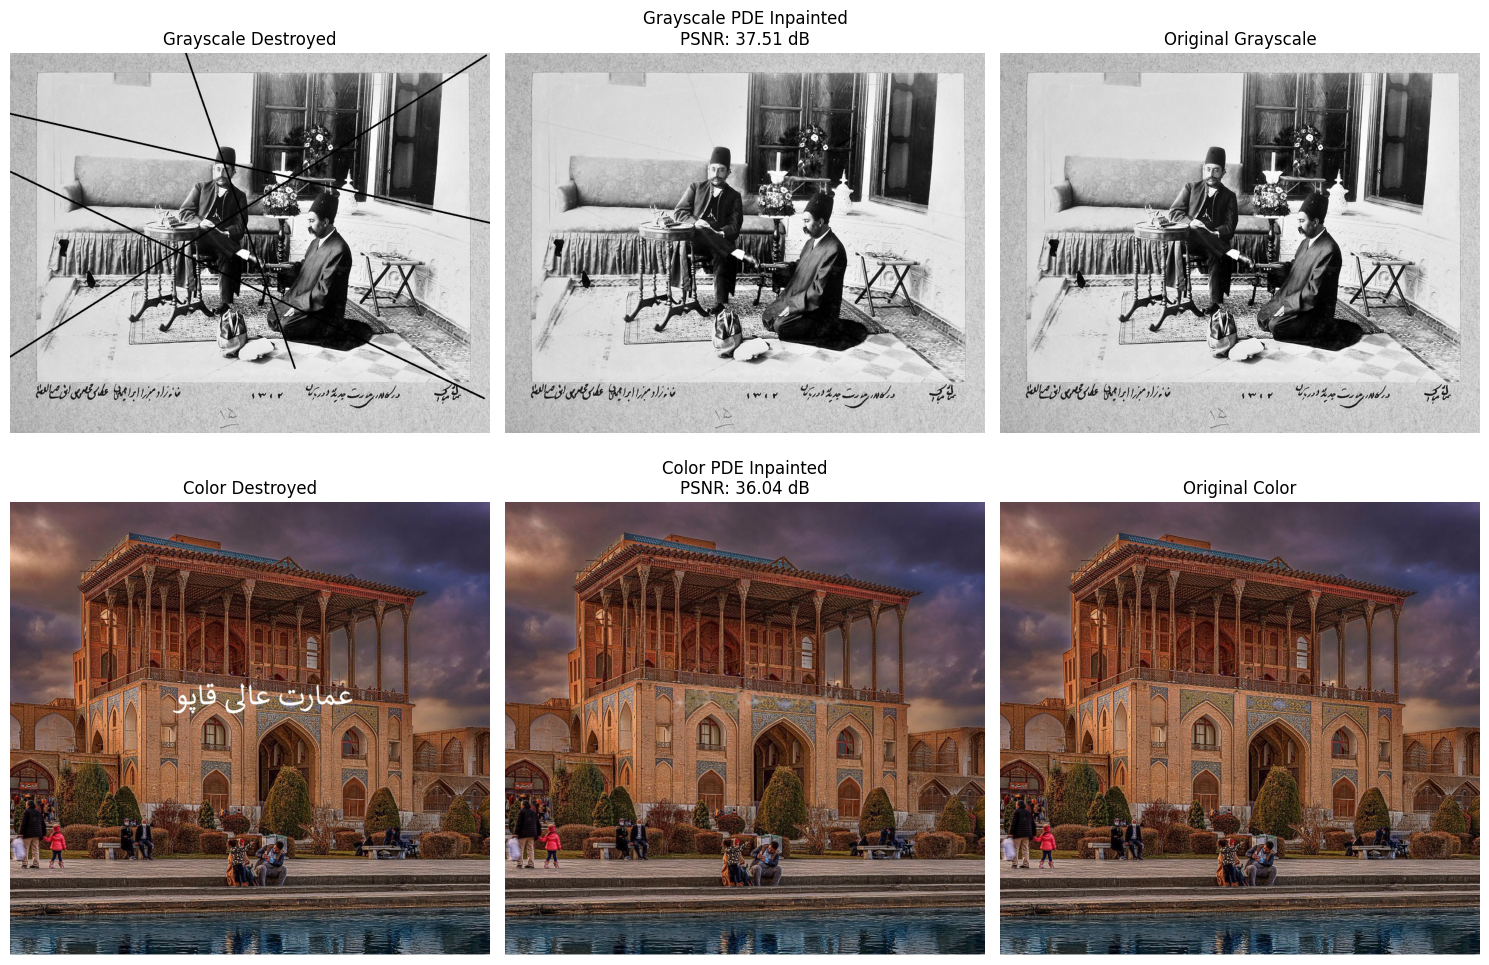

In [ ]:
# Display results
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].imshow(gray_destroyed_norm, cmap='gray')
axs[0, 0].set_title('Grayscale Destroyed')

axs[0, 1].imshow(gray_pde_inpainted, cmap='gray')
axs[0, 1].set_title(f'Grayscale PDE Inpainted\nPSNR: {psnr_gray_pde:.2f} dB')

axs[0, 2].imshow(gray_image_norm, cmap='gray')
axs[0, 2].set_title('Original Grayscale')

axs[1, 0].imshow(color_destroyed_norm)
axs[1, 0].set_title('Color Destroyed')

axs[1, 1].imshow(color_pde_inpainted)
axs[1, 1].set_title(f'Color PDE Inpainted\nPSNR: {psnr_color_pde:.2f} dB')

axs[1, 2].imshow(color_image_norm)
axs[1, 2].set_title('Original Color')

for ax in axs.flat:
    ax.axis('off')
plt.tight_layout()
plt.show()

# H.

'Explanation of this part in the report.'

# I.

λ=0.05, dt=0.02

In [58]:
gray_inpainted_exp1 = pde_inpainting(gray_destroyed_norm, gray_mask, lambda_param=0.05, num_iter=5000, dt=0.02)
color_inpainted_exp1 = pde_inpainting_color(color_destroyed_norm, color_mask, lambda_param=0.05, num_iter=5000, dt=0.02)

# Compute PSNR
psnr_gray_exp1 = psnr(gray_image_norm, gray_inpainted_exp1)
psnr_color_exp1  = psnr(color_image_norm, color_inpainted_exp1)

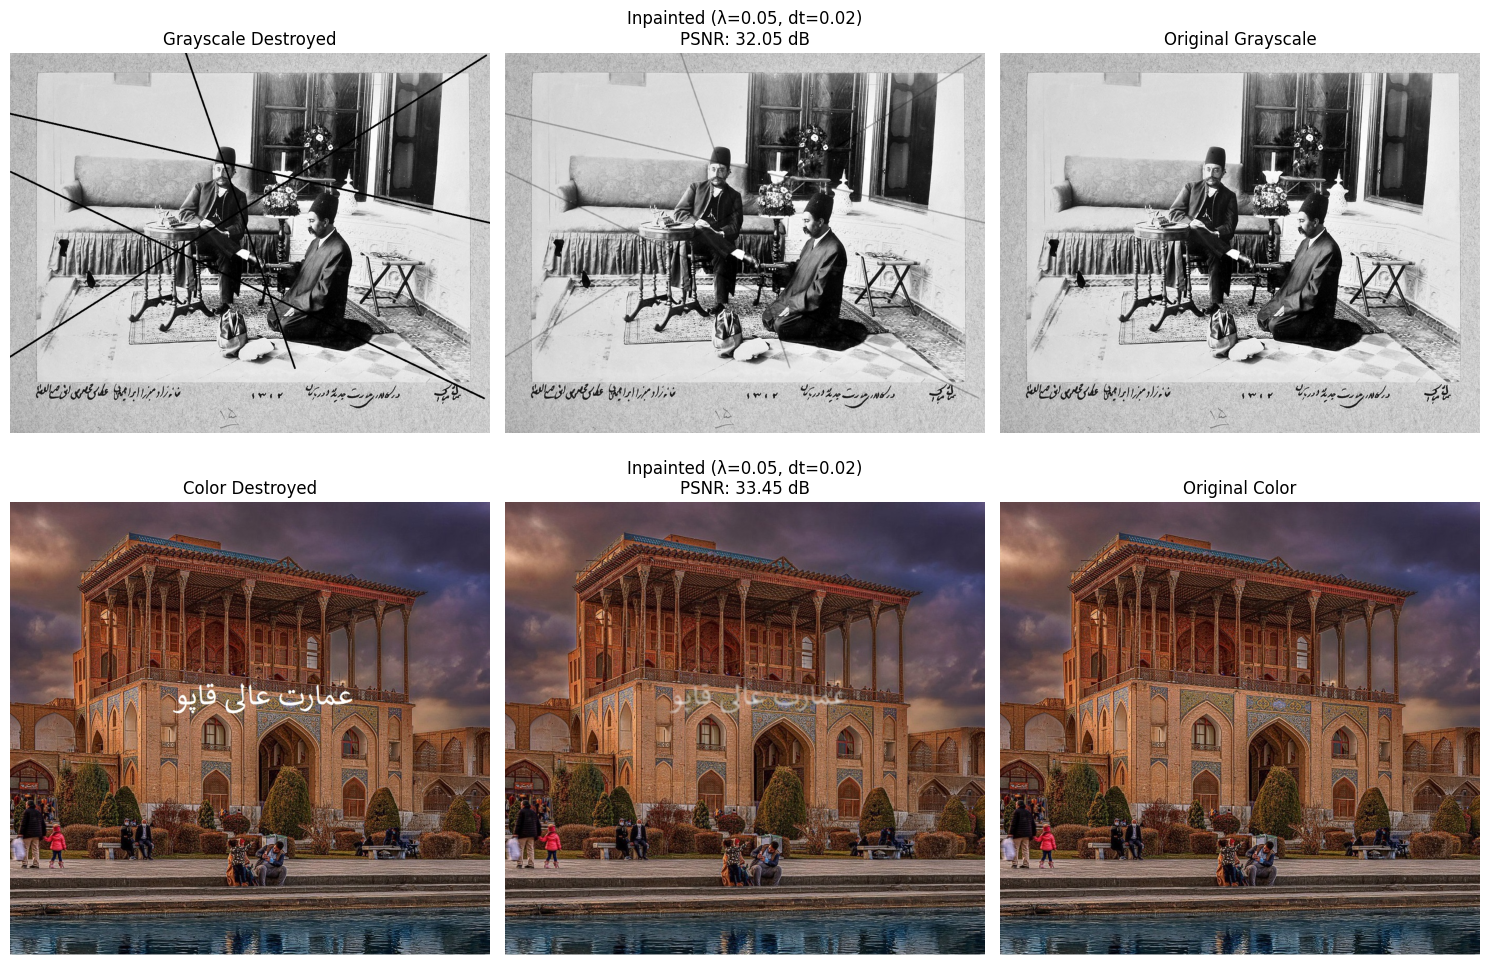

In [ ]:
# Display results for Experiment 1 
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Grayscale
axs[0, 0].imshow(gray_destroyed_norm, cmap='gray')
axs[0, 0].set_title('Grayscale Destroyed')

axs[0, 1].imshow(gray_inpainted_exp1, cmap='gray')
axs[0, 1].set_title(f'Inpainted (λ=0.05, dt=0.02)\nPSNR: {psnr_gray_exp1:.2f} dB')

axs[0, 2].imshow(gray_image_norm, cmap='gray')
axs[0, 2].set_title('Original Grayscale')

# Color
axs[1, 0].imshow(color_destroyed_norm)
axs[1, 0].set_title('Color Destroyed')

axs[1, 1].imshow(color_inpainted_exp1)
axs[1, 1].set_title(f'Inpainted (λ=0.05, dt=0.02)\nPSNR: {psnr_color_exp1:.2f} dB')

axs[1, 2].imshow(color_image_norm)
axs[1, 2].set_title('Original Color')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

λ=0.01, dt=0.05

In [60]:
gray_inpainted_exp2 = pde_inpainting(gray_destroyed_norm, gray_mask, lambda_param=0.01, num_iter=5000, dt=0.05)
color_inpainted_exp2 = pde_inpainting_color(color_destroyed_norm, color_mask, lambda_param=0.01, num_iter=5000, dt=0.05)

# Compute PSNR
psnr_gray_exp2 = psnr(gray_image_norm, gray_inpainted_exp2)
psnr_color_exp2 = psnr(color_image_norm, color_inpainted_exp2)

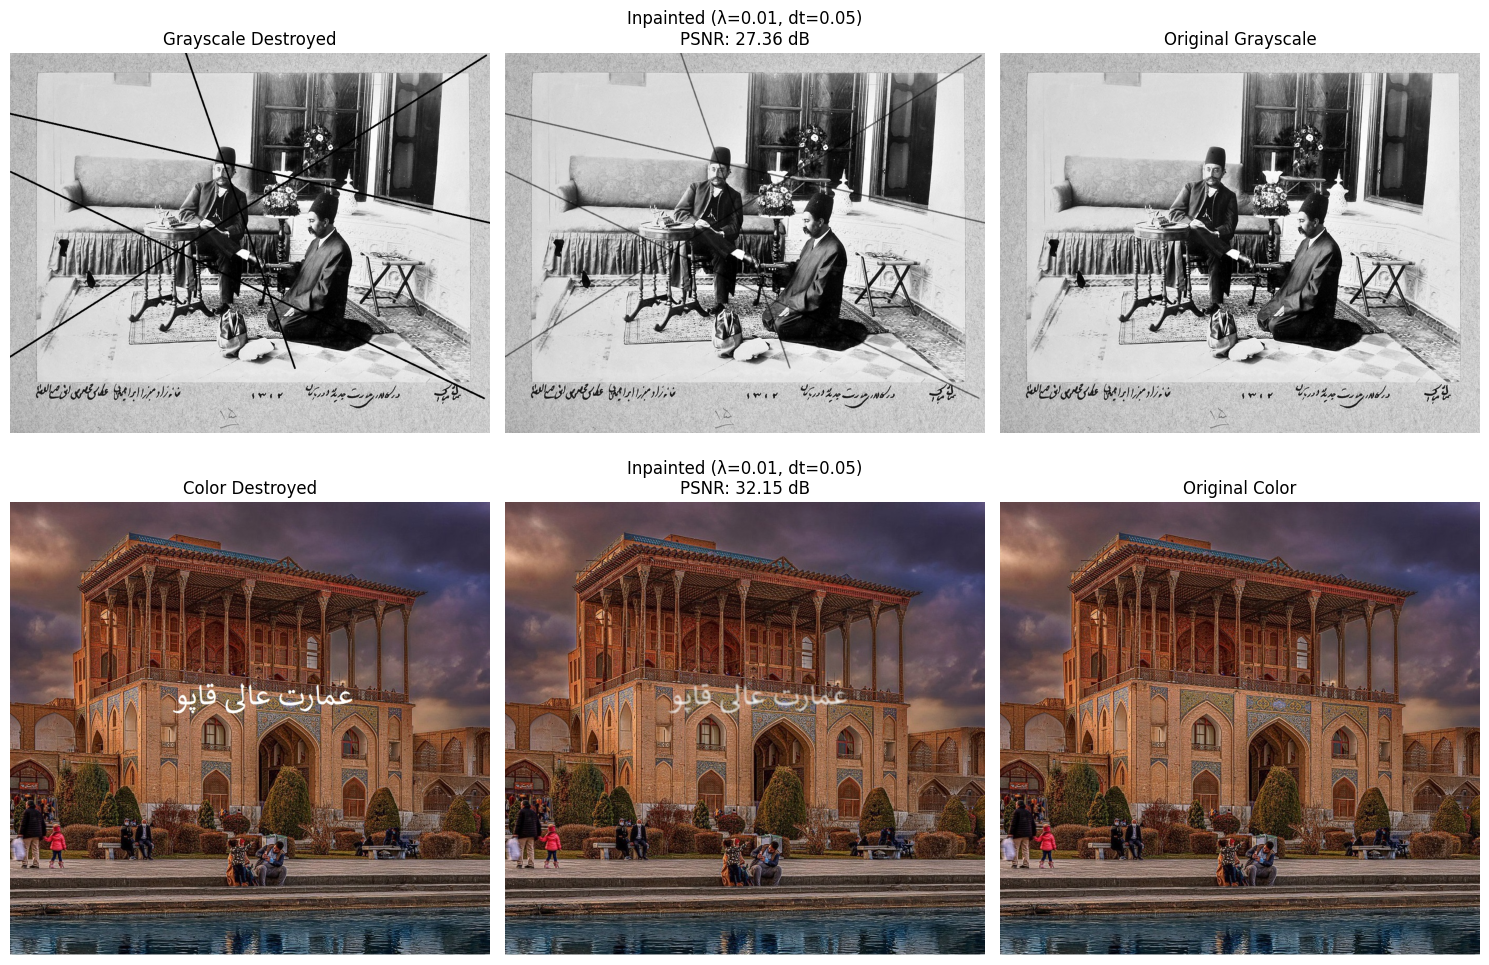

In [ ]:
# Display results for Experiment 2
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Grayscale
axs[0, 0].imshow(gray_destroyed_norm, cmap='gray')
axs[0, 0].set_title('Grayscale Destroyed')

axs[0, 1].imshow(gray_inpainted_exp2, cmap='gray')
axs[0, 1].set_title(f'Inpainted (λ=0.01, dt=0.05)\nPSNR: {psnr_gray_exp2:.2f} dB')

axs[0, 2].imshow(gray_image_norm, cmap='gray')
axs[0, 2].set_title('Original Grayscale')

# Color
axs[1, 0].imshow(color_destroyed_norm)
axs[1, 0].set_title('Color Destroyed')

axs[1, 1].imshow(color_inpainted_exp2)
axs[1, 1].set_title(f'Inpainted (λ=0.01, dt=0.05)\nPSNR: {psnr_color_exp2:.2f} dB')

axs[1, 2].imshow(color_image_norm)
axs[1, 2].set_title('Original Color')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

# J.

'Explanation of this part in the report.'

# K.

'Explanation of this part in the report.'

# L.

In [70]:
# Compute MSE
def mse(original, restored):
    return np.mean((original - restored) ** 2)

# MSE for grayscale and color interpolation methods
mse_gray_interp_nearest = mse(gray_image_norm, gray_inpainted_nearest)  
mse_gray_interp_linear = mse(gray_image_norm, gray_inpainted_linear)  

mse_color_interp_nearest = mse(color_image_norm, color_inpainted_nearest)
mse_color_interp_linear = mse(color_image_norm, color_inpainted_linear)

# MSE for PDE method
mse_gray_pde = mse(gray_image_norm, gray_pde_inpainted)
mse_color_pde = mse(color_image_norm, color_pde_inpainted)

print(f"MSE Grayscale Nearest Interpolation: {mse_gray_interp_nearest:.6f}")
print(f"MSE Grayscale Linear Interpolation: {mse_gray_interp_linear:.6f}")
print(f"MSE Color Nearest Interpolation: {mse_color_interp_nearest:.6f}")
print(f"MSE Color Linear Interpolation: {mse_color_interp_linear:.6f}")

print(f"MSE Grayscale PDE: {mse_gray_pde:.6f}")
print(f"MSE Color PDE: {mse_color_pde:.6f}")

MSE Grayscale Nearest Interpolation: 0.000221
MSE Grayscale Linear Interpolation: 0.000139
MSE Color Nearest Interpolation: 0.000170
MSE Color Linear Interpolation: 0.000132
MSE Grayscale PDE: 0.000178
MSE Color PDE: 0.000249


# M.

'Explanation of this part in the report.'